This is the copy of Flow Matching notebook. It is to see how smaller model will behave.

In [3]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from tqdm.notebook import tqdm

from src.model. models import DBModel
from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

In [4]:
import pandas as pd

class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.groupby("angle").head(100)
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx], dtype=torch.int64)

        return weights, angle

In [5]:
class Flow(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Flow, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(36, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, 33)
        )
    
    def forward(self, x):
        return self.layers(x)

In [6]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0


def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
epochs = 1000
lr = 1e-3
batch_size = 100
hidden_dim = 512

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow(hidden_dim)
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../models/generators/flow_matching_small/"
model_path = path + "flow_small_conditional.pth"


In [32]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

    if epoch % 200 == 0:
        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate(flow, angle)[0]
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            
            accuracies_per_epoch.append(np.mean(accuracies))
            torch.save(flow.state_dict(), f"{path}flow_matching_{epoch}.pth")
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 3.7666163444519043


C:\Users\JetFire\AppData\Local\Temp\ipykernel_26540\4236868358.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 10: Loss 3.048095941543579
Epoch 20: Loss 3.3158020973205566
Epoch 30: Loss 2.9104456901550293
Epoch 40: Loss 3.000023126602173
Epoch 50: Loss 2.656207323074341
Epoch 60: Loss 2.6449148654937744
Epoch 70: Loss 2.719987392425537
Epoch 80: Loss 2.664802312850952
Epoch 90: Loss 2.842017889022827
Epoch 100: Loss 2.962918996810913
Epoch 110: Loss 2.7761356830596924
Epoch 120: Loss 2.612194538116455
Epoch 130: Loss 2.66023325920105
Epoch 140: Loss 2.550048828125
Epoch 150: Loss 2.8533647060394287
Epoch 160: Loss 2.486966848373413
Epoch 170: Loss 2.7341248989105225
Epoch 180: Loss 2.7573442459106445
Epoch 190: Loss 3.0909011363983154
Epoch 200: Loss 2.520671844482422
Epoch 210: Loss 2.742457389831543
Epoch 220: Loss 2.782411813735962
Epoch 230: Loss 2.461636543273926
Epoch 240: Loss 2.647841453552246
Epoch 250: Loss 2.6259453296661377
Epoch 260: Loss 2.543607473373413
Epoch 270: Loss 2.9269306659698486
Epoch 280: Loss 2.367095708847046
Epoch 290: Loss 2.584324598312378
Epoch 300: Loss 2

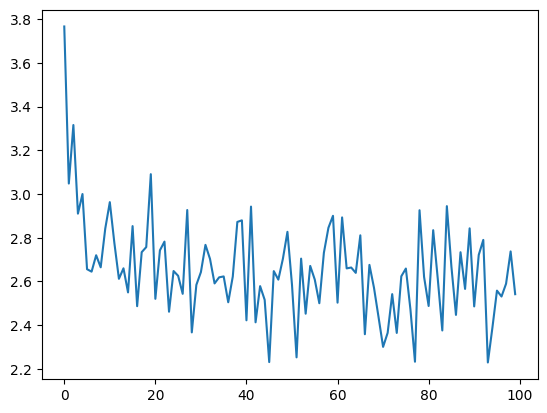

In [33]:
plt.plot(losses)

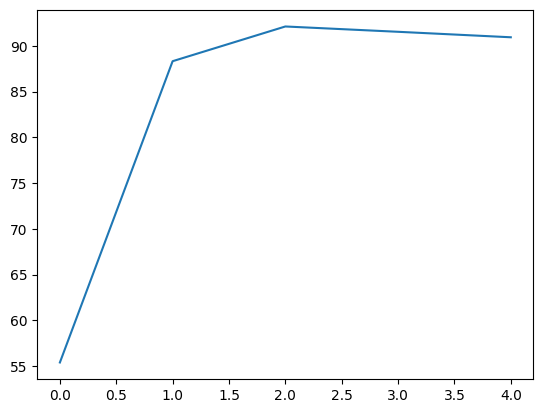

In [34]:
plt.plot(accuracies_per_epoch)


## Conditional Generation

In [8]:
def generate(model, angle, num_iter=100):
    x = gaussian.sample((1,))
    angle = torch.tensor([angle*torch.pi/180])
    for i in np.linspace(0, 1, num_iter, endpoint=False):
        t = torch.tensor([i], dtype=torch.float32)
        sin = torch.sin(angle)
        cos = torch.cos(angle)
        path = model(torch.cat([x, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        x += (0.01 * path)
    return x.detach()

In [9]:
flow = Flow(hidden_dim)
flow.load_state_dict(torch.load(model_path))
flow.eval()

def slider(angle):
    x = generate(flow, angle, num_iter=100)[0]
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    plot_decision_boundary(x, X_rotated, y, title=f"{angle}° degrees")

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_6568\4100408927.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 92.6845


<Axes: ylabel='Density'>

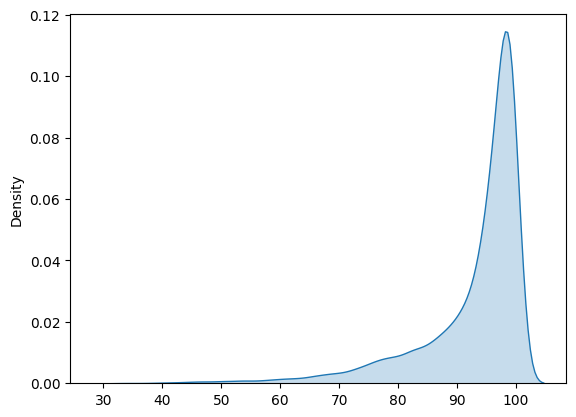

In [ ]:
flow = Flow(hidden_dim)
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_6568\2328032824.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 91.313925


<Axes: ylabel='Density'>

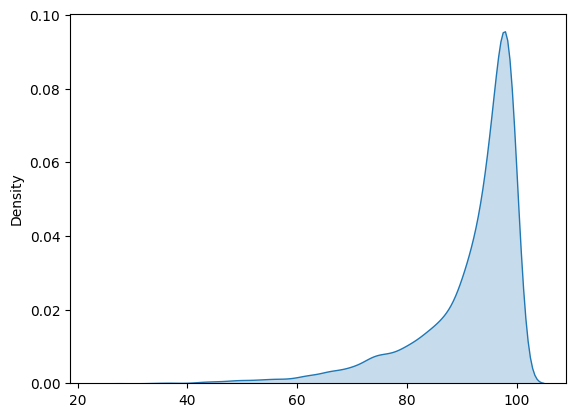

In [11]:
flow = Flow(hidden_dim)
flow.load_state_dict(torch.load(model_path))
flow.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## Parameters distribution

In [29]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

angle = 0
accuracies = []

X, y = get_moons_dataset()
X = torch.tensor(X, dtype=torch.float32)

for i in range(1000):
    parameters = generate(flow, angle, num_iter=100)[0]
    accuracy = get_accuracy(parameters, X, y)
    accuracies.append(accuracy)
    
print("Mean accuracy:", np.mean(accuracies))

Mean accuracy: 93.38789999999999


(33, 1000)


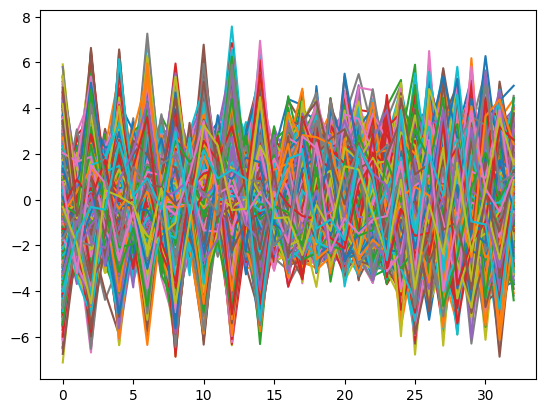

In [19]:
parameters = np.array(parameters)
print(parameters.T.shape)

plt.plot(parameters.T)
plt.show()